Tutorial 5. Working with Variational Autoencoders
==================================================

Based on: http://kvfrans.com/variational-autoencoders-explained/

This is the fifth notebook of Neural Wrappers and presents the implementation of a classic VAE. A variational autoencoder is an extension of the classic autonencoder.

```
yEnc = encoder(x)
yDec = decoder(yEnc)
L = Loss(yDec, x)
```

The mai difference is that now, instead of using directly the codes of the encoder, we use it to encode the input into a unit gaussian vector, parametrized by a mean and a std vector. Then, we'll generate a random value from the actual unit gaussian and multiply it by our prediction. Then, we'll have two loss components, one that forces the encoder to be unit gaussian, by minimizing KL-Divergence, and the other that forces the decoder to take this unit gaussian vector and reconstruct the original input.

```
μEnc, σEnc = encoder(x)
Z = N(O, 1) * σEnc + μEnc
yDec = decoder(Z)

LEnc = KL(N(O, 1), N(σEnc, μEnc))
LDec = Loss(yDec, x)
L = α * LEnc + LDec
```

### 1. Definining the Reader

We'll use the MNIST dataset again, however, for this example, we'll just use a binary version of it.

In [1]:
import numpy as np
from neural_wrappers.readers import MNISTReader
from neural_wrappers.utilities import getGenerators

class BinaryMNISTReader(MNISTReader):
    def iterateOneEpoch(self, type, miniBatchSize):
        for items in super().iterateOneEpoch(type, miniBatchSize):
            images, _ = items
            images = np.float32(images > 0)
            yield images, images

reader = BinaryMNISTReader("/home/mihai/Public/Datasets/MNIST/dataset.h5")
print(reader.summary())

generator, numSteps = getGenerators(reader, batchSize=20, keys=["train"])
print("Train steps:", numSteps)

[H5DatasetReader::sanitizeDimGetter] Adding default dimGetter for 'labels'
[Dataset summary]
General dataset reader (<class '__main__.BinaryMNISTReader'>). Update __str__ in your dataset for more details when using summary.
Data buckets:
 -  data:['rgb']
 -  labels:['labels']

Train steps: 3000


#### 2. Defining the Encoder and the Decoder networks.

The encoder takes a binarized MNIST image of shape 28x28x1 and outputs two vectors, the mean and the standard deviation of this input, which should represent a value somewhere sampled from the unit gaussian.

The decoder takes these two values and tries to reconstruct the original input image.

In [2]:
import torch as tr
import torch.nn as nn
import torch.nn.functional as F

from neural_wrappers.pytorch import FeedForwardNetwork

class Encoder(FeedForwardNetwork):
    def __init__(self, noiseSize):
        super().__init__()
        self.noiseSize = noiseSize
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 100)
        self.mean_fc = nn.Linear(100, noiseSize)
        self.mean_std = nn.Linear(100, noiseSize)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        y1 = F.relu(self.fc1(x))
        y2 = F.relu(self.fc2(y1))
        y_mean = self.mean_fc(y2)
        y_std = self.mean_std(y2)
        return y_mean, y_std

class Decoder(FeedForwardNetwork):
    def __init__(self, noiseSize):
        super().__init__()
        self.noiseSize = noiseSize
        self.fc1 = nn.Linear(noiseSize, 300)
        self.fc2 = nn.Linear(300, 28 * 28)

    def forward(self, z_samples):
        y1 = F.relu(self.fc1(z_samples))
        y2 = self.fc2(y1)
        y_decoder = tr.sigmoid(y2)
        return y_decoder

/usr/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
encoder = Encoder(100)
decoder = Decoder(100)

print(encoder.summary())
print(decoder.summary())

[Model summary]
General neural network architecture. Update __str__ in your model for more details when using summary.
Parameters count: 108800. Trainable parameters: 108800.
Hyperparameters:
Metrics:
	- Loss (min)
Callbacks:
	
Optimizer: ['None']
Optimizer Scheduler: None
GPU: False
[Model summary]
General neural network architecture. Update __str__ in your model for more details when using summary.
Parameters count: 266284. Trainable parameters: 266284.
Hyperparameters:
Metrics:
	- Loss (min)
Callbacks:
	
Optimizer: ['None']
Optimizer Scheduler: None
GPU: False


#### 2.1 Wrapping the models inside a VAE model.

We'll wrap the two models inside a VAE model that implements the logic defined earlier. We'll also define a callback that plots the results at the end of each epoch, to see the evolution

In [4]:
from neural_wrappers.pytorch import VariationalAutoencoderNetwork, device, npToTrCall
from neural_wrappers.pytorch.variational_autoencoder_network import latentLossFn, decoderLossFn
from neural_wrappers.callbacks import SaveModels, PlotMetrics, Callback
import matplotlib.pyplot as plt
import torch.optim as optim

class SampleResultsCallback(Callback):
    def onEpochEnd(self, **kwargs):
        model = kwargs["model"]
        noise = np.random.randn(25, model.decoder.noiseSize).astype(np.float32)
        results = model.decoder.npForward(noise)
        results = results.reshape(5, 5, 28, 28) > 0.5

        plt.gcf().clf()
        ax = plt.subplots(5, 5)[1]
        for i in range(5):
            for j in range(5):
                ax[i, j].imshow(results[i, j], cmap="gray")
        plt.show()
        plt.close()

# Define model
model = VariationalAutoencoderNetwork(encoder, decoder, \
    lossWeights={"latent" : 1 / 2000, "decoder" : 1}).to(device)
model.addMetrics({
    "Reconstruction Loss" : lambda y, t, **k : npToTrCall(decoderLossFn, y, t),
    "Latent Loss" : lambda y, t, **k : npToTrCall(latentLossFn, y, t)
})
model.addCallbacks([SaveModels("last", "Loss"), SampleResultsCallback(), \
    PlotMetrics(["Loss", "Reconstruction Loss", "Latent Loss"])])
model.setOptimizer(optim.SGD, lr=0.01, momentum=0.9)

print(model.summary())

[Model summary]
General neural network architecture. Update __str__ in your model for more details when using summary.
Parameters count: 375084. Trainable parameters: 375084.
Hyperparameters:
Metrics:
	- Loss (min)
	- Reconstruction Loss (min)
	- Latent Loss (min)
Callbacks:
	SaveModels (Metric: Loss. Type: last) | <__main__.SampleResultsCallback object at 0x7f3a25175880> | PlotMetrics (Loss, Loss, Reconstruction Loss, Latent Loss)
Optimizer: ['SGD. Learning rate: 0.01, Momentum: 0.9, Dampening: 0, Weight Decay: 0, Nesterov: False']
Optimizer Scheduler: None
GPU: False


#### 3. Training the model

This is a standard training pipeline that looks identical to previous tutorials. Also, for each epoch, we'll print a few samples to see the model's improvement in time using a custom callback.

Training for 10 epochs starting from epoch 1




[SaveModels] Epoch 1. Saved last model


<Figure size 432x288 with 0 Axes>

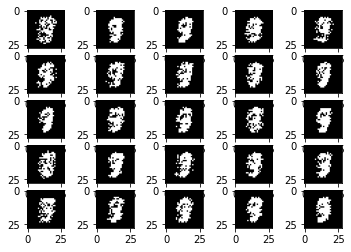


[SaveModels] Epoch 2. Saved last model


<Figure size 432x288 with 0 Axes>

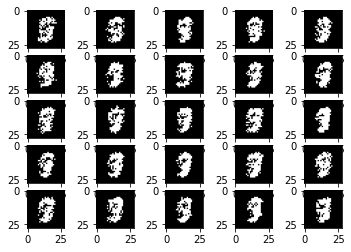


[SaveModels] Epoch 3. Saved last model


<Figure size 432x288 with 0 Axes>

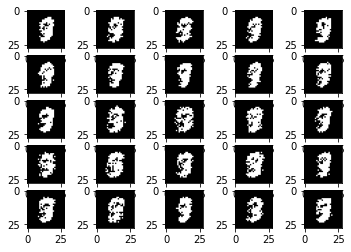


[SaveModels] Epoch 4. Saved last model


<Figure size 432x288 with 0 Axes>

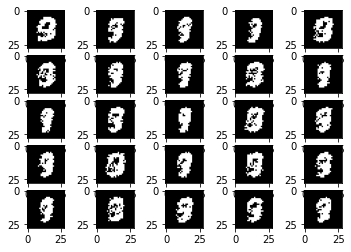


[SaveModels] Epoch 5. Saved last model


<Figure size 432x288 with 0 Axes>

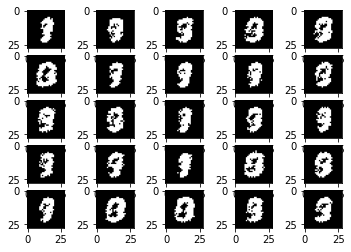


[SaveModels] Epoch 6. Saved last model


<Figure size 432x288 with 0 Axes>

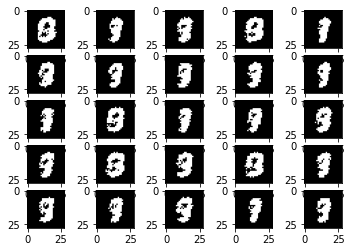


[SaveModels] Epoch 7. Saved last model


<Figure size 432x288 with 0 Axes>

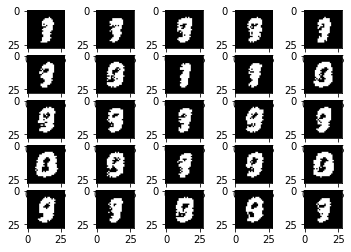


[SaveModels] Epoch 8. Saved last model


<Figure size 432x288 with 0 Axes>

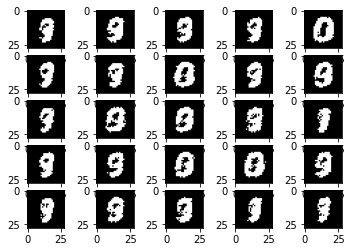


[SaveModels] Epoch 9. Saved last model


<Figure size 432x288 with 0 Axes>

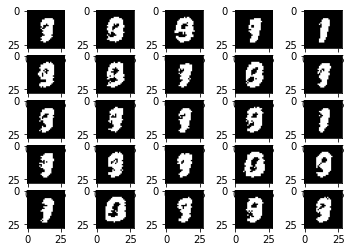


[SaveModels] Epoch 10. Saved last model


<Figure size 432x288 with 0 Axes>

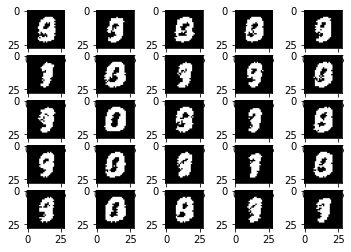

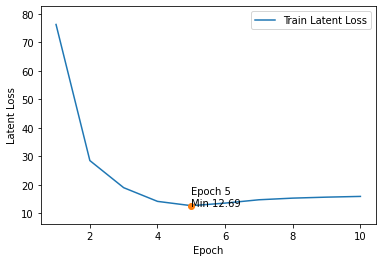

In [5]:
model.train_generator(generator, numSteps, numEpochs=10)

#### 4. Testing the model

We'll pick the latest stored model and generate some samples from random noise to see its quality as well as discriminator's response.

Loading model from model_last.pkl
Succesfully loaded weights (375084 parameters) 
Succesfully loaded optimizer: ['SGD. Learning rate: 0.01, Momentum: 0.9, Dampening: 0, Weight Decay: 0, Nesterov: False']
Succesfully loaded model history (epoch 10)
Succesfully loaded 6 callbacks (3 metrics)
Finished loading model


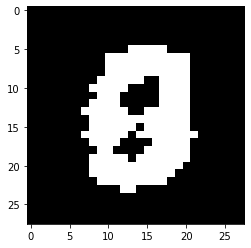

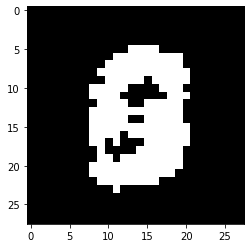

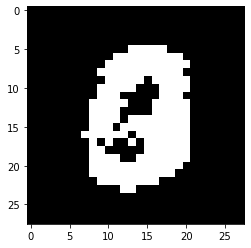

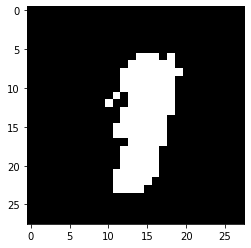

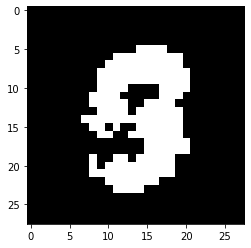

In [ ]:
import numpy as np
model.loadModel("model_last.pkl")

while True:
    noise = np.random.randn(1, model.decoder.noiseSize).astype(np.float32)
    results = model.decoder.npForward(noise)
    results = results.reshape(28, 28) > 0.5
    plt.gcf().clf()
    plt.gcf().gca().imshow(results, cmap="gray")    
    plt.show()
    plt.close()
    input()